In [1]:
from neural_bandits.modules.neural_ucb_module import NeuralUCBBanditModule
from neural_bandits.datasets.statlog import StatlogDataset

import lightning as pl
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import Subset
import random

In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [3]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

network = Network(dataset.context_size * dataset.num_actions, hidden_size=100)

n_samples = 15000
indices = list(range(len(dataset)))
random.shuffle(indices)
subset_indices = indices[:n_samples]
mini_dataset = Subset(dataset, subset_indices)
print("Subset size:", len(mini_dataset))

train_loader = DataLoader(mini_dataset, batch_size=1, shuffle=True)
model = NeuralUCBBanditModule(
        n_features = dataset.context_size * dataset.num_actions,
        network=network,
        early_stop_threshold=1e-3,
        num_grad_steps=1000,
        lambda_=0.00001,
        nu=0.00001,
        learning_rate=1e-3,
        train_freq=100,
        initial_train_steps=2000,
        max_grad_norm=20.0,
)

logger = pl.pytorch.loggers.CSVLogger("logs", name="neural_ucb", flush_logs_every_n_steps=100)
trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


7
58000
Subset size: 15000


In [ ]:
trainer.fit(model, train_loader)

In [18]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

# metrics_csv = logger.log_dir + "/metrics.csv"
# print(metrics_csv)
metrics = pd.read_csv("logs\\neural_ucb\\version_94\\metrics.csv")
cumulative_reward = np.cumsum(metrics["reward"][:15000])
cumulative_regret = np.cumsum(metrics["regret"][:15000])

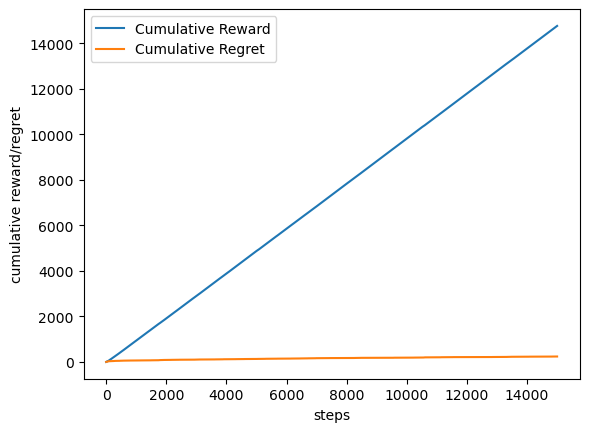

In [19]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward, label='Cumulative Reward')
plt.plot(cumulative_regret, label='Cumulative Regret')
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [20]:
# average reward
print(sum(metrics["reward"][:10]) / 10)
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:15000]) / 15000)

print(sum(metrics["regret"][:10]) / 10)
print(sum(metrics["regret"][:100]) / 100)
print(sum(metrics["regret"][:15000]) / 15000)

0.5
0.68
0.9841333333333333
0.5
0.32
0.015866666666666668
